In [69]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re

In [70]:
# Necessary headers
headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

base_url = "https://api.c3.ai/covid/api/1"

In [45]:
def fetch_data(url, headers=None, data=None):
    hasMore = True
    
    data['spec']['limit'] = -1
    data['spec']['offset'] = 0
    
    results = []
    
    while hasMore:
        r = requests.post(url,
                          headers=headers,
                          data=json.dumps(data))
        if r.status_code != 200:
            raise RuntimeError("Problem fetching data! {} ({})".format(r.text, r.request.body))
        
        res_json = json.loads(r.text)
        hasMore = res_json['hasMore']
        data['spec']['offset'] += res_json['count']
        
        results += res_json['objs']
    
    result_df = pd.DataFrame(results)
    result_df = result_df.set_index('id')
    return result_df

In [46]:
data = {
    'spec': {
        'include': 'symptoms, gender, age, ageRange, outcome, didDie, didRecover, symptomStartDate, caseConfirmationDate, outcomeDate, hospitalAdmissionDate',
        'limit': -1,
        'offset': 0,
    }
}

linelistrecord_df = fetch_data(os.path.join(base_url, 'linelistrecord', 'fetch'),
                               headers=headers,
                               data=data)

In [66]:
?sorted

In [88]:
all_symptoms = {}
for symptomlist in list(linelistrecord_df[linelistrecord_df.symptoms.notna()].symptoms.values):
    symptoms = re.split('[,;:][ ]?', symptomlist.strip().lower())
    for symptom in symptoms:
        try:
            all_symptoms[symptom] += 1
        except KeyError:
            all_symptoms[symptom] = 1

symptoms = list(all_symptoms.keys())
symptoms = sorted(symptoms, key=lambda s: all_symptoms[s], reverse=True)
print(symptoms[:20])

['fever', 'cough', 'mild', 'sore throat', 'moderate', 'pneumonia', 'headache', 'mild to moderate', 'fatigue', 'malaise', 'runny nose', 'chills', 'pneumonitis', 'shortness of breath', 'acute respiratory distress syndrome', 'diarrhea', 'joint pain', 'sputum', 'dyspnea', 'phlegm']


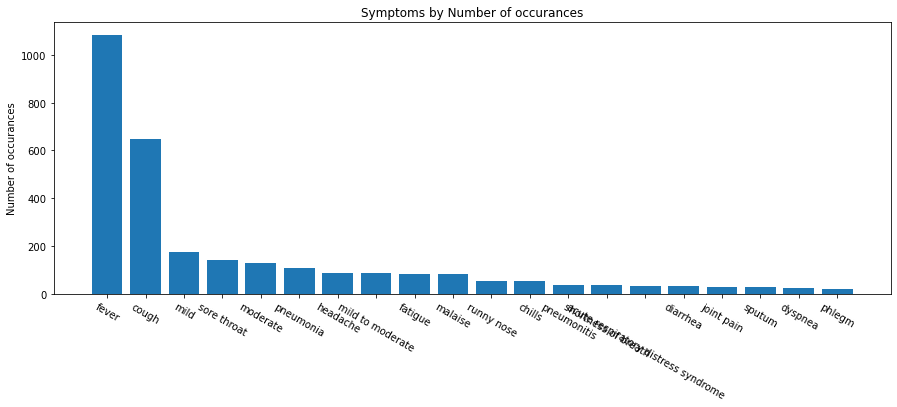

In [94]:
most_common_symptoms = symptoms[:20]
_, ax = plt.subplots(1, figsize=(15, 5))
ax.bar(most_common_symptoms, [all_symptoms[key] for key in most_common_symptoms])
ax.set_ylabel('Number of occurances')
ax.set_title("Symptoms by Number of occurances")
plt.xticks(rotation=-30)
plt.show()